In [1]:
from scipy.spatial import cKDTree
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SimPEG import *

In [3]:
mesh = Utils.meshutils.readUBCTensorMesh("./models/mesh_composite.msh")
sigma = Utils.meshutils.readUBCTensorModel("./models/sigmaInf_composite_cond.con", mesh)

In [4]:
from simpegem1d import EM1DAnal

In [5]:
from scipy.constants import mu_0
def genTensorMesh(locs, sigma=1e-3, t=1e-2, dx=np.r_[50., 50., 35.], ncx=5,ncy=5,ncz=4,npad=9):    
    difdist = np.sqrt(2*t/mu_0/sigma)
    hx = [(dx[0],npad,-1.3), (dx[0],ncx), (dx[0],npad,1.3)]
    hy = [(dx[1],npad,-1.3), (dx[1],ncy), (dx[1],npad,1.3)]
    hz = [(dx[2],npad-2,-1.3), (dx[2],ncz),(dx[2]*0.5, 4),(dx[2],ncz),(dx[2],npad-2,1.3)]
    mesh = Mesh.TensorMesh([hx, hy, hz], x0="CCC")
    mesh._x0 += locs
    print locs
    return mesh    

In [6]:
#Step1: make a tree
inactind = mesh.gridCC[:,2] > 0.
tree = cKDTree(zip(mesh.gridCC[~inactind,0], mesh.gridCC[~inactind,1], mesh.gridCC[~inactind,2]))

In [7]:
hx = np.ones(20)*100
hy = np.ones(11)*150
meshsurvey = Mesh.TensorMesh([hx,hy,], "CC")
locs = np.c_[meshsurvey.gridCC, np.ones(meshsurvey.nC)*-30.]
itx = Utils.closestPoints(meshsurvey, np.r_[0., 0.])[0]

In [8]:
# for i in range(220):
meshsub = genTensorMesh(locs[itx,:])
inactindsub = meshsub.gridCC[:,2] > 0.
#Step2: find indices of the nearest neighbors in the flattened array
d, inds = tree.query(zip(meshsub.gridCC[~inactindsub,0],meshsub.gridCC[~inactindsub,1],meshsub.gridCC[~inactindsub,2]), k=1)
sigma_nearest = np.ones(meshsub.nC)*1e-8
#Step2_1: Generate an interpolation matrix
P = sp.coo_matrix( (np.ones(inds.size),(np.arange(inds.size), inds)), shape=(inds.size, (~inactind).sum()) )
out = P*sigma[~inactind]
sigma_nearest[~inactindsub] = out

[-50.   0. -30.]


In [9]:
inds.shape

(7935,)

In [10]:
d.shape

(7935,)

In [11]:
P.tocsc()

<7935x72000 sparse matrix of type '<type 'numpy.float64'>'
	with 7935 stored elements in Compressed Sparse Column format>

In [12]:
#Step3: interpolate using inverse distance weighting, using 10 nearest neighbours(k=10)
d, inds = tree.query(zip(meshsub.gridCC[~inactindsub,0],meshsub.gridCC[~inactindsub,1],meshsub.gridCC[~inactindsub,2]), k=6)
w = 1./ d**2
sigma_idw = np.ones(meshsub.nC)*1e-8
sigma_idw[~inactindsub] = np.exp(np.sum(w*np.log(sigma[inds]), axis = 1) / np.sum(w, axis=1))
w = Utils.sdiag(1./np.sum(w, axis=1))*w 
I = Utils.mkvc(np.arange(inds.shape[0]).reshape([-1,1]).repeat(6, axis=1))
J = Utils.mkvc(inds)
P = sp.coo_matrix( (Utils.mkvc(w),(I, J)), shape=(inds.shape[0], (~inactind).sum()) )
out = np.exp(P*np.log(sigma[~inactind]))
sigma_idw = np.ones(meshsub.nC)*1e-8
sigma_idw[~inactindsub] = out

In [13]:
d.shape

(7935, 6)

In [16]:
(~inactindsub).sum()

7935

In [28]:
inds.shape

(7935, 6)

In [14]:
class Mesh2MeshTopo(IdentityMap):
    """
        Takes a model on one mesh are translates it to another mesh
        with consideration of topography

    """
    tree = None
    nIterpPts = 6

    def __init__(self, meshes, actinds, **kwargs):
        Utils.setKwargs(self, **kwargs)

        assert type(meshes) is list, "meshes must be a list of two meshes"
        assert len(meshes) == 2, "meshes must be a list of two meshes"
        assert type(actinds) is list, "actinds must be a list of two meshes"
        assert len(actinds) == 2, "actinds must be a list of two meshes"
        assert meshes[0].dim == meshes[1].dim, """The two meshes must be the same dimension"""

        self.mesh  = meshes[0]
        self.mesh2 = meshes[1]
        self.actind = actinds[0]
        self.actind2 = actinds[1]
        self.getP()

        # Old version using SimPEG interpolation
        # self.P = self.mesh2.getInterpolationMat(self.mesh.gridCC,'CC',zerosOutside=True)
    
    from scipy.interpolate import NearestNDInterpolator        
    def genActiveindfromTopo(mesh, xyztopo):    
        #TODO: This possibly needs to be improved use vtk(?)
        if mesh.dim==3:
            nCxy = mesh.nCx*mesh.nCy
            Zcc = mesh.gridCC[:,2].reshape((nCxy, mesh.nCz), order='F')
            Ftopo = NearestNDInterpolator(xyztopo[:,:2], xyztopo[:,2])
            XY = Utils.ndgrid(mesh.vectorCCx, mesh.vectorCCy)
            XY.shape
            topo = Ftopo(XY)
            actind = []                    
            for ixy in range(nCxy):
                actind.append(topo[ixy] <= Zcc[ixy,:])
        else:
            raise NotImplementedError("Only 3D is working")

        return Utils.mkvc(np.vstack(actind))

    #Question .. is it only generated once?
    def getP(self):
        """

        """
        if self.tree==None:
            self.tree = cKDTree(zip(self.mesh.gridCC[self.actind,0], self.mesh.gridCC[self.actind,1], self.mesh.gridCC[self.actind,2]))
        d, inds = tree.query(zip(self.mesh2.gridCC[self.actind2,0],self.mesh2.gridCC[self.actind2,1],self.mesh2.gridCC[self.actind2,2]), k=self.nIterpPts)
        w = 1./ d**2
        w = Utils.sdiag(1./np.sum(w, axis=1)) * w
        I = Utils.mkvc(np.arange(inds.shape[0]).reshape([-1,1]).repeat(6, axis=1))
        J = Utils.mkvc(inds)
        P = sp.coo_matrix( (Utils.mkvc(w),(I, J)), shape=(inds.shape[0], (self.actind).sum()) )
        self.P = P.tocsc() 

    @property
    def shape(self):
        """Number of parameters in the model."""
        # return (self.mesh.nC, self.mesh2.nC)
        return (self.actind2.sum(), self.actind.sum())

    @property
    def nP(self):
        """Number of parameters in the model."""
        # return self.mesh2.nC
        return self.actind2.sum()

    def _transform(self, m):
        return self.P*m

    def deriv(self, m):
        return self.P

NameError: name 'IdentityMap' is not defined

In [121]:
M2Mmap = Mesh2MeshTopo([mesh, meshsub], [~inactind, ~inactindsub])
actmap = Maps.ActiveCells(meshsub, ~inactindsub, np.log(1e-8))
expmap = Maps.ExpMap(meshsub)
mapping = expmap*actmap*M2Mmap
test = mapping*np.log(sigma[~inactind])

-24.99


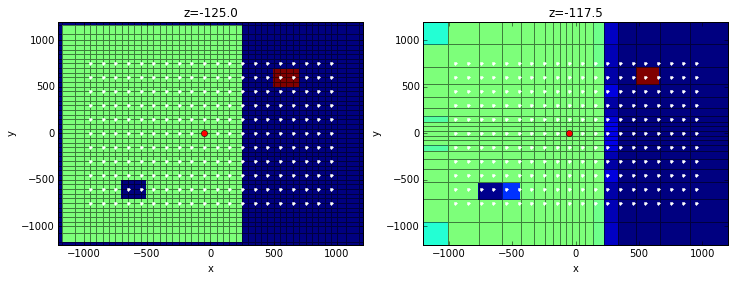

In [124]:
fig = plt.figure(figsize = (12, 4))
ax = plt.subplot(121)
print mesh.vectorCCz[19]
indz = 17
mesh.plotSlice(np.log10(sigma), ind = indz, grid=True, clim=(-3, -1), ax=ax)
ax.plot(meshsurvey.gridCC[:,0],meshsurvey.gridCC[:,1], 'w.')
ax.plot(meshsurvey.gridCC[itx,0],meshsurvey.gridCC[itx,1], 'ro')
ax.set_xlim(-1200, 1200)
ax.set_ylim(-1200, 1200)
ax.set_title(("z=%3.1f")%(mesh.vectorCCz[indz])) 
ax1 = plt.subplot(122)
indzsub = 9
meshsub.plotSlice(np.log10(test), ind = indzsub, grid=True, clim=(-3, -1), ax=ax1)
ax1.plot(meshsurvey.gridCC[:,0],meshsurvey.gridCC[:,1], 'w.')
ax1.plot(meshsurvey.gridCC[itx,0],meshsurvey.gridCC[itx,1], 'ro')
ax1.set_xlim(-1200, 1200)
ax1.set_ylim(-1200, 1200)
ax1.set_title(("z=%3.1f")%(meshsub.vectorCCz[indzsub])) 

(-1000, 1000)

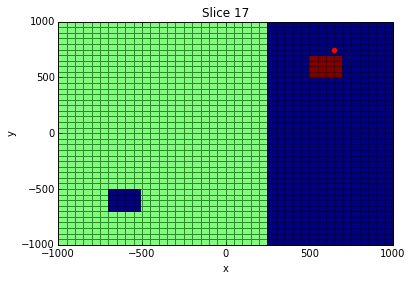

In [125]:
itx = 216
mesh.plotSlice(np.log10(sigma), ind = 17, grid=True, clim=(-3, -1))
plt.plot(meshsurvey.gridCC[itx,0],meshsurvey.gridCC[itx,1], 'ro')
xlim(-1000, 1000)
ylim(-1000, 1000)

(-1000, 1000)

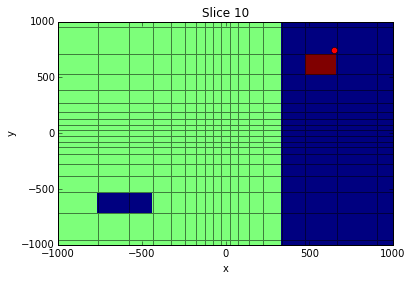

In [126]:
meshsub.plotSlice(np.log10(sigma_nearest), ind = 10, grid=True, clim=(-3, -1))
plt.plot(meshsurvey.gridCC[itx,0],meshsurvey.gridCC[itx,1], 'ro')
xlim(-1000, 1000)
ylim(-1000, 1000)

(-1000, 1000)

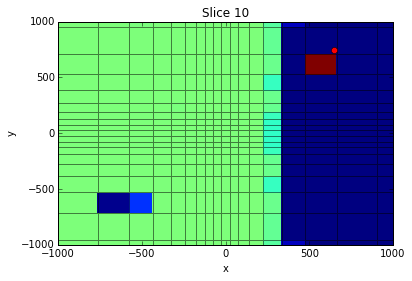

In [127]:
meshsub.plotSlice(np.log10(sigma_idw), ind = 10, grid=True, clim=(-3, -1))
plt.plot(meshsurvey.gridCC[itx,0],meshsurvey.gridCC[itx,1], 'ro')
xlim(-1000, 1000)
ylim(-1000, 1000)

(-1000, 1000)

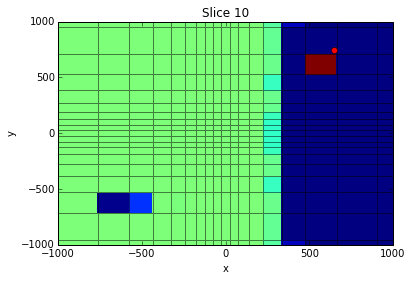

In [128]:
meshsub.plotSlice(np.log10(test), ind = 10, grid=True, clim=(-3, -1))
plt.plot(meshsurvey.gridCC[itx,0],meshsurvey.gridCC[itx,1], 'ro')
xlim(-1000, 1000)
ylim(-1000, 1000)

(-1000, 1000)

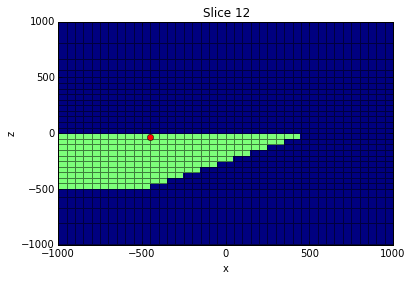

In [129]:
itx = 45
mesh.plotSlice(np.log10(sigma), ind = 12,normal='Y', grid=True, clim=(-3, -1))
plt.plot(locs[itx,0],locs[itx,2], 'ro')
xlim(-1000, 1000)
ylim(-1000, 1000)

(-1000, 1000)

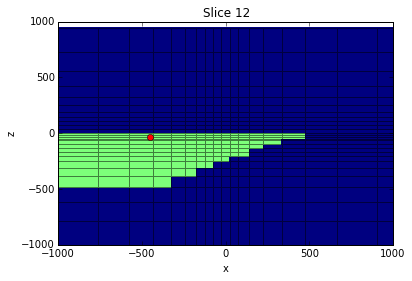

In [130]:
itx = 45
meshsub.plotSlice(np.log10(sigma_nearest), ind = 12, normal='Y', grid=True, clim=(-3, -1))
plt.plot(locs[itx,0],locs[itx,2], 'ro')
xlim(-1000, 1000)
ylim(-1000, 1000)

(-1000, 1000)

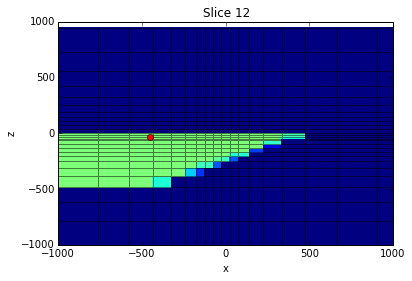

In [131]:
itx = 45
meshsub.plotSlice(np.log10(sigma_idw), ind = 12, normal='Y', grid=True, clim=(-3, -1))
plt.plot(locs[itx,0],locs[itx,2], 'ro')
xlim(-1000, 1000)
ylim(-1000, 1000)